## **Algorithmic Detection of Credit Card Defaulting**
#### **Final Project Phase 2**
*Tanvi Namjoshi, Dylan Van Bramer, Madeline Demers, Ella White*

In this report, we perform an initial examination of the dataset obtained from UC Irvine in 2016, focusing on credit card clients in Taiwan who have defaulted. Building a predictive model to assess the likelihood of customer defaulting requires fairness to prevent discrimination based on sensitive features. Defaulting on a credit card is defined as failing to make the minimum payment for at least 180 days. We plan to explore whether we can find a risk prediction model that is fair across different subgroups (male/female, education) that still remains accurate. 

The original source for the data can be found here: [https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients](https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients)

#### **Previous Work**
Our previous work involved auditing the Rotterdam welfare fraud detection algorithm using the synthetic dataset and model obtained by the data journalists at Lighthouse Reports and Wired. We spent the first half of our time working on Phase 2 using that dataset. This included translating the feature names from Dutch to English, calculating summary statistics for the dataset, and attempting to train an unsupervised model on the data provided. However, we decided to pivot from this to the credit card defaulting data for two main reasons. First, as noted in the methodology article from Lighthouse Reports, we do not have any of the target values about whether or not the individual did infact commit fraud. This made it extremely difficult for us to analyze the accuracy of the model used by the government in Rotterdam as well as our own model. Realistically, we would have only been able to use statisical parity as a metric for fairness, and we would have no ground truth labels. Secondly, the provided model was in R, and while we were able to load it into our notebook, the strucutre of the model was extremely unclear. We were unable to successfully use the Rotterdam model on the dataset. For these reasons we have pivoted to algorithmic detection of credit card defaulting.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
#from aif360.sklearn.metrics import statistical_parity_difference

#### **Data Import and Cleaning**

In [6]:
# Import the data
og_df = pd.read_csv('UCI_CC_defaulting.csv', skiprows=[0])

# Clean the data by dropping the additional first column, which is just an ID. 
# We can use index number as identification.  
og_df.drop(og_df.columns[0], axis=1, inplace=True)

# Display the Data
og_df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [7]:
#In order to clean, we first check for missing values
missing_values = og_df.isnull().sum()
print(missing_values)

if missing_values.sum() == 0:
    print("No missing values found.")
else:
    print("There are missing values.")


LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64
No missing values found.


In [8]:
# Next, we check the data types. 
data_types = og_df.dtypes
print(data_types)

LIMIT_BAL                     int64
SEX                           int64
EDUCATION                     int64
MARRIAGE                      int64
AGE                           int64
PAY_0                         int64
PAY_2                         int64
PAY_3                         int64
PAY_4                         int64
PAY_5                         int64
PAY_6                         int64
BILL_AMT1                     int64
BILL_AMT2                     int64
BILL_AMT3                     int64
BILL_AMT4                     int64
BILL_AMT5                     int64
BILL_AMT6                     int64
PAY_AMT1                      int64
PAY_AMT2                      int64
PAY_AMT3                      int64
PAY_AMT4                      int64
PAY_AMT5                      int64
PAY_AMT6                      int64
default payment next month    int64
dtype: object


To clean our data further, we will re-format some of this information using one-hot encoding. From our data source, we know the dataset is structured as follows: 
* SEX: 1 = male, 2 = female 
* EDUCATION: 1 = graduate school, 2= university; 3 = high school; 4 = others
* MARRIAGE: 1 = married; 2 = single; 3 = others

In [9]:
# Create the one-hot encodings. For each feature, we first assert that all the info provided by the dataset creators is accurate. 
# After that, we create the one-hot encodings

clean_df = og_df
# SEX
if clean_df["SEX"].nunique() == 2 and np.array_equal(clean_df["SEX"].unique(), np.array([2,1])):
  print("resuts for SEX column match expectations")
else:
  # the above assertion failed. Let us remove all rows that do not match our expectations
  clean_df = clean_df[clean_df['SEX'].between(1,2)]
  assert (clean_df["SEX"].nunique() == 2) 
  print("removed SEX columns that did not mach expectations")


# EDUCATION
if clean_df["EDUCATION"].nunique() == 4:
  print("resuts for EDUCATION column match expectations")
else:
  # the above assertion failed. Let us remove all rows that do not match our expectations
  clean_df = clean_df[clean_df['EDUCATION'].between(1, 4)]
  assert (clean_df["EDUCATION"].nunique() == 4) 
  print("removed EDUCATION columns that did not mach expectations")


# MARRIAGE
if clean_df["MARRIAGE"].nunique() == 3:
  print("resuts for MARRIAGE column match expectations")
else:
  # the above assertion failed. Let us remove all rows that do not match our expectations
  clean_df = clean_df[clean_df['MARRIAGE'].between(1, 3)]
  assert (clean_df["MARRIAGE"].nunique() == 3) 
  print("removed MARRIAGE columns that did not mach expectations")

old_rows = og_df.count()[0]
new_rows = clean_df.count()[0]
print("The number of datapoints with bad values was ", old_rows - new_rows)

clean_df = pd.get_dummies(clean_df, columns=['SEX', 'EDUCATION', 'MARRIAGE' ], dtype=int)
column_names = {"SEX_1": "SEX_male", "SEX_2": "SEX_female", "EDUCATION_1": "graduate_education", "EDUCATION_2": "university_education", "EDUCATION_3": "highschool_education", "EDUCATION_4": "other_education"}
column_names.update({"MARRIAGE_1": "married", "MARRIAGE_2": "single", "MARRIAGE_3": "marriage_other"})
clean_df.rename(columns=column_names, errors="raise", inplace=True)
display(clean_df.head())

print("Finished creating one-hot encoding")



resuts for SEX column match expectations
removed EDUCATION columns that did not mach expectations
removed MARRIAGE columns that did not mach expectations
The number of datapoints with bad values was  399


,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,default payment next month,SEX_male,SEX_female,graduate_education,university_education,highschool_education,other_education,married,single,marriage_other
0,20000,24,2,2,-1,-1,-2,-2,3913,3102,...,1,0,1,0,1,0,0,1,0,0
1,120000,26,-1,2,0,0,0,2,2682,1725,...,1,0,1,0,1,0,0,0,1,0
2,90000,34,0,0,0,0,0,0,29239,14027,...,0,0,1,0,1,0,0,0,1,0
3,50000,37,0,0,0,0,0,0,46990,48233,...,0,0,1,0,1,0,0,1,0,0
4,50000,57,-1,0,-1,0,0,0,8617,5670,...,0,1,0,0,1,0,0,1,0,0


Finished creating one-hot encoding


#### **Summary Statistics**


#### Part 2(a)

In [10]:
# Part 2 (a)
rows = clean_df.count()[0]
columns = len(clean_df.columns)
print("Looking at the whole dataset:")
print("There are", rows, "rows of data in the dataframe")
print("There are", columns, "features/columns in the dataframe")


#Per sensitive attribute subgroup

#Gender 
female_idx = clean_df.index[clean_df["SEX_female"]==1]
male_idx = clean_df.index[clean_df["SEX_male"] == 1]
print("\nLooking at the dataset by gender:")
print("The number of data points where the person's gender is female is: ", len(female_idx))
print("The number of data points where the person's gender is male is: ", len(male_idx))

#Education 
graduate_idx = clean_df.index[clean_df["graduate_education"]==1]
university_idx = clean_df.index[clean_df["university_education"] == 1]
highschool_idx = clean_df.index[clean_df["highschool_education"] == 1]
other_education_idx = clean_df.index[clean_df["other_education"] == 1]

print("\nLooking at the dataset by education:")
print("The number of data points where the person has a graduate education is: ", len(graduate_idx))
print("The number of data points where the person has a univeristy education is: ", len(university_idx))
print("The number of data points where the person has a high school education is: ", len(highschool_idx))
print("The number of data points where the person has none of the above is: ", len(other_education_idx))


# Marriage Status
single_df = clean_df[clean_df['single'] == 1]
married_df = clean_df[clean_df['married'] == 1]
other_df = clean_df[clean_df['marriage_other'] == 1]
rows_married = married_df.shape[0]  
rows_single = single_df.shape[0]  
rows_other = other_df.shape[0]  

print("\nLooking at the dataset by marriage status:")
print("There are", rows_married, "datapoints where the person is married")
print("There are", rows_single, "datapoints where the person is single")
print("There are", rows_other, "datapoints where the person identifies as neither married or single")

#AGE 
under_fifty = clean_df.index[clean_df["AGE"]<50]
over_fifty = clean_df.index[clean_df["AGE"] >= 50]

print("\nLooking at the dataset by AGE:")
print("The number of data points where the person is under 50: ", len(under_fifty))
print("The number of data points where the person is over 50: ", len(over_fifty))




Looking at the whole dataset:
There are 29601 rows of data in the dataframe
There are 30 features/columns in the dataframe

Looking at the dataset by gender:
The number of data points where the person's gender is female is:  17855
The number of data points where the person's gender is male is:  11746

Looking at the dataset by education:
The number of data points where the person has a graduate education is:  10581
The number of data points where the person has a univeristy education is:  14024
The number of data points where the person has a high school education is:  4873
The number of data points where the person has none of the above is:  123

Looking at the dataset by marriage status:
There are 13477 datapoints where the person is married
There are 15806 datapoints where the person is single
There are 318 datapoints where the person identifies as neither married or single

Looking at the dataset by AGE:
The number of data points where the person is under 50:  26967
The number of d

#### Part 2(b)
Our outcome variable of interest is whether the individual defaults on their payment next month. In our dataset that is the variable `default payment next month`, which is either 0 or 1.

In [35]:
outcome_variable = 'default payment next month'

defulated_individuals = clean_df.index[clean_df[outcome_variable]==1]
non_defulated_individuals = clean_df.index[clean_df[outcome_variable]==0]


mean_value = clean_df[outcome_variable].mean()
median_value = clean_df[outcome_variable].median()
std_dev_value = clean_df[outcome_variable].std()

# Print the results
print("Outcome variable:", outcome_variable)
print("\nOverall Statistics")
print("Number of data points where the person defaulted:",len(defulated_individuals))
print("Number of data points where the person did not default:",len(non_defulated_individuals))
print("Mean:", mean_value)
print("Median:", median_value)
print("Standard Deviation:", std_dev_value)


Outcome variable: default payment next month

Overall Statistics
Number of data points where the person defaulted: 6605
Number of data points where the person did not default: 22996
Mean: 0.2231343535691362
Median: 0.0
Standard Deviation: 0.4163547406844319


In [12]:

#Gender
print("\nStatistics by Gender")
mean_value = clean_df[outcome_variable][female_idx].mean()
median_value = clean_df[outcome_variable][female_idx].median()
std_dev_value = clean_df[outcome_variable][female_idx].std()
print("Mean for Females:", mean_value)
print("Median for Females :", median_value)
print("Standard Deviation for Females:", std_dev_value)

mean_value = clean_df[outcome_variable][male_idx].mean()
median_value = clean_df[outcome_variable][male_idx].median()
std_dev_value = clean_df[outcome_variable][male_idx].std()
print("Mean for Males:", mean_value)
print("Median for Males:", median_value)
print("Standard Deviation for Males:", std_dev_value)


Statistics by Gender
Mean for Females: 0.20968916269952395
Median for Females : 0.0
Standard Deviation for Females: 0.40709814501924513
Mean for Males: 0.24357227992508088
Median for Males: 0.0
Standard Deviation for Males: 0.4292557646242155


In [13]:
#Edcuation
print("\nStatistics by Education")
mean_value = clean_df[outcome_variable][graduate_idx].mean()
median_value = clean_df[outcome_variable][graduate_idx].median()
std_dev_value = clean_df[outcome_variable][graduate_idx].std()
print("Mean for People with Graduate Education:", mean_value)
print("Median for People with Graduate Education ", median_value)
print("Standard Deviation for Graduate Education:", std_dev_value)


mean_value = clean_df[outcome_variable][university_idx].mean()
median_value = clean_df[outcome_variable][university_idx].median()
std_dev_value = clean_df[outcome_variable][university_idx].std()
print("Mean for People with University Education:", mean_value)
print("Median for People with University Education:", median_value)
print("Standard Deviation for University Education:", std_dev_value)

mean_value = clean_df[outcome_variable][highschool_idx].mean()
median_value = clean_df[outcome_variable][highschool_idx].median()
std_dev_value = clean_df[outcome_variable][highschool_idx].std()
print("Mean for People with High School Education:", mean_value)
print("Median for People with High School Education ", median_value)
print("Standard Deviation for High School Education:", std_dev_value)


mean_value = clean_df[outcome_variable][other_education_idx].mean()
median_value = clean_df[outcome_variable][other_education_idx].median()
std_dev_value = clean_df[outcome_variable][other_education_idx].std()
print("Mean for People with Other Education:", mean_value)
print("Median for People with Other Education:", median_value)
print("Standard Deviation for Other Education:", std_dev_value)


Statistics by Education
Mean for People with Graduate Education: 0.19242037614592195
Median for People with Graduate Education  0.0
Standard Deviation for Graduate Education: 0.39422006872642057
Mean for People with University Education: 0.2373787792355961
Median for People with University Education: 0.0
Standard Deviation for University Education: 0.42549148512838436
Mean for People with High School Education: 0.25302688282372254
Median for People with High School Education  0.0
Standard Deviation for High School Education: 0.43479083865008655
Mean for People with Other Education: 0.056910569105691054
Median for People with Other Education: 0.0
Standard Deviation for Other Education: 0.23261919236784867


In [14]:
#Edcuation
print("\nStatistics by Marriage")
mean_value = married_df[outcome_variable].mean()
median_value = married_df[outcome_variable].median()
std_dev_value = married_df[outcome_variable].std()
print("Mean for married people:", mean_value)
print("Median for married people:", median_value)
print("Standard Deviation for married people:", std_dev_value)


mean_value = single_df[outcome_variable].mean()
median_value = single_df[outcome_variable].median()
std_dev_value = single_df[outcome_variable].std()
print("Mean for single people:", mean_value)
print("Median for single people:", median_value)
print("Standard Deviation for single people:", std_dev_value)

mean_value = other_df[outcome_variable].mean()
median_value = other_df[outcome_variable].median()
std_dev_value = other_df[outcome_variable].std()
print("Mean for People with Other Marriage Status:", mean_value)
print("Median for People with Other Marriage Status:", median_value)
print("Standard Deviation for Other Marriage:", std_dev_value)


Statistics by Marriage
Mean for married people: 0.2368479631965571
Median for married people: 0.0
Standard Deviation for married people: 0.425163989931608
Mean for single people: 0.2106162216879666
Median for single people: 0.0
Standard Deviation for single people: 0.40775917907231995
Mean for People with Other Marriage Status: 0.2641509433962264
Median for People with Other Marriage Status: 0.0
Standard Deviation for Other Marriage: 0.4415749014017929


In [15]:
print("\nStatistics by Age")

mean_value = clean_df[outcome_variable][under_fifty].mean()
median_value = clean_df[outcome_variable][under_fifty].median()
std_dev_value = clean_df[outcome_variable][under_fifty].std()
print("Mean for People Under 50:", mean_value)
print("Median for People Under 50 ", median_value)
print("Standard Deviation for People Under 50:", std_dev_value)

mean_value = clean_df[outcome_variable][over_fifty].mean()
median_value = clean_df[outcome_variable][over_fifty].median()
std_dev_value = clean_df[outcome_variable][over_fifty].std()
print("Mean for People Over 50:", mean_value)
print("Median for People Over 50 ", median_value)
print("Standard Deviation for People Over 50:", std_dev_value)





Statistics by Age
Mean for People Under 50: 0.21989839433381542
Median for People Under 50  0.0
Standard Deviation for People Under 50: 0.41418528699333007
Mean for People Over 50: 0.25626423690205014
Median for People Over 50  0.0
Standard Deviation for People Over 50: 0.4366523376693046


#### Part 2(c)
c. Plot at least as many figures as your # group members, and explain concisely but
meaningfully what the plot shows in markdown text

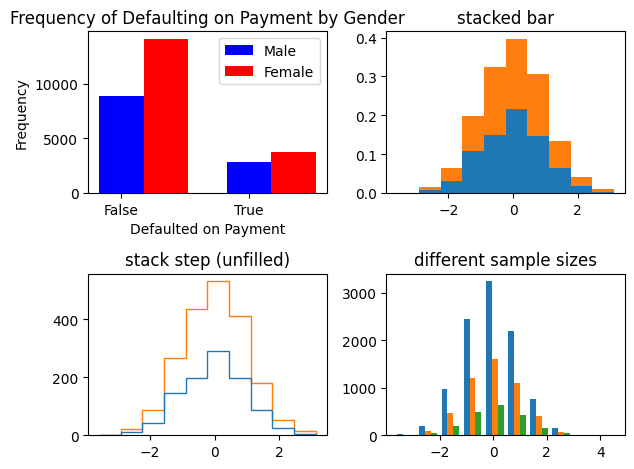

In [16]:
n_bins = 10
x = np.random.randn(1000, 2)

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2)

bar_width = 0.35

female0 = sum(clean_df[outcome_variable][female_idx]==0)
female1 = sum(clean_df[outcome_variable][female_idx]==1)
male0 = sum(clean_df[outcome_variable][male_idx]==0)
male1 = sum(clean_df[outcome_variable][male_idx]==1)
ax0.bar([0,1], [male0, male1],  bar_width, color='b',label='Male')
ax0.bar(np.array([0,1])+bar_width, [female0, female1],  bar_width, color='r',label='Female')
ax0.legend(prop={'size': 10})
ax0.set_xlabel('Defaulted on Payment')
ax0.set_xticks([0,1], ('False', 'True'))
ax0.set_ylabel('Frequency')
ax0.set_title('Frequency of Defaulting on Payment by Gender')

ax1.hist(x, n_bins, density=True, histtype='bar', stacked=True)
ax1.set_title('stacked bar')

ax2.hist(x, n_bins, histtype='step', stacked=True, fill=False)
ax2.set_title('stack step (unfilled)')

# Make a multiple-histogram of data-sets with different length.
x_multi = [np.random.randn(n) for n in [10000, 5000, 2000]]
ax3.hist(x_multi, n_bins, histtype='bar')
ax3.set_title('different sample sizes')

fig.tight_layout()
plt.show()

#### **Research Question, Hypotheses, and Analysis Plan**

a. Concretely, what is (are) your research question(s)? Be specific: what are the
inputs, outputs, and evaluation metrics you are interested in, and why?
b. What are your hypotheses?
i. E.g., do you notice any potential biases from your summary statistics?
What are they, and why might these exist?
c. What analyses are you going to run (in section 4) to test your hypotheses
presented above?

Research Question: Is it possible to fairly predict the risk of an indvidual defaulting on their credit card?
Hypotheses?: young, ummarried people that are college or lower level of education (irresponsible when younger?), take into account the fact that this is data from Tawian not USA
Evaluation Metrics: 
- calibrationl goal to improve this
- statisical parity; at least evaluate this

#### **Modeling**

a. You should run at least as many analyses as there are # group members.
i. E.g., if you have 3 group members, and your project is to find a risk
prediction model / method that balances fairness with accuracy, you may
want to try one logistic regression with [a subset of variables], one logistic
regression with [upsampling methods for minority groups in the training
data], and one random forest with [a different subset of variables].
ii. E.g., if you have 3 group members, and your project is to audit a dataset
for diversity, you could perform three separate analyses of the data – one
comparing the dataset makeup to the true underlying distribution by one sensitive attribute, a second similar comparison by a different sensitive
attribute, and an insertion of additional (collected or synthetic) data to
balance the dataset by sensitive attributes.
b. You should report evaluation metrics for each model, including by subgroup (for
your sensitive attribute(s) of interest).
i. If applicable, you should also include significance testing (e.g., report
p-values).
c. You should include informative plot(s) about your models.
i. E.g., you could plot ROC curves, or comparisons of fairness metrics
and/or performance across different models.


In [17]:
df = clean_df

# Obtain our X and Y values
Y = df['default payment next month']
Y = [int(y) for y in Y]
X = df.drop('default payment next month', axis=1)

In [53]:
# Include all features
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25,)

# Don't evaluate on sensitive features
protected_cols = ['graduate_education','university_education','highschool_education', 'other_education','married','single','marriage_other','SEX_male','SEX_female', 'AGE']
idx = X.index
df_no_sensitive = X.copy().drop(protected_cols, axis=1)
X_train1, X_test1, y_train1, y_test1, train_idx, test_idx = train_test_split(df_no_sensitive, Y, idx, test_size=0.25,)
X_full_test = X[X.index.isin(test_idx)]
female_idx_sensitive = X_full_test.index[X_full_test["SEX_female"]==1]
male_idx_sensitive = X_full_test.index[X_full_test["SEX_male"]==1]
print("Data with no sensitive features")
display(df_no_sensitive.head())

Data with no sensitive features


,LIMIT_BAL,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0
1,120000,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [19]:
threshold = 0.5
results_all = pd.DataFrame(X_test)
results_all["Ground Truth"] =  y_test
results_no_sensitive = pd.DataFrame(X_test1)
results_no_sensitive["Ground Truth"] =  y_test1

# All Data
logreg = LogisticRegression(penalty=None, max_iter = 1000).fit(X_train,y_train)
probs = logreg.predict_proba(X_test)[:,1]
results_all['Logistic Regression All Vars Prob'] = probs
preds = (probs > threshold).astype(int)
results_all['Logistic Regression All Vars Pred'] = preds
print("The accuracy score for LogReg using all features is:", accuracy_score(preds, y_test))

rf = RandomForestClassifier(n_estimators=100,)
rf.fit(X_train, y_train)
probs = rf.predict_proba(X_test)[:,1]
results_all['RF All Vars Prob'] = probs
preds = (probs > threshold).astype(int)
results_all['RF All Vars Pred'] = preds

print("The accuracy score for a Random Forest Classifier using all features is:", accuracy_score(preds, np.array(y_test)))


# No sensitive features
logreg1 = LogisticRegression(penalty=None,max_iter = 1000).fit(X_train1,y_train1)
probs = logreg1.predict_proba(X_test1)[:,1]
results_no_sensitive['Logistic Regression No Sensitive Vars Prob'] = probs
preds = (probs > threshold).astype(int)
results_no_sensitive['Logistic Regression No Sensitive Vars Pred'] = preds
print("The accuracy score for LogReg excluding sensitive features is:", accuracy_score(preds, y_test1))

rf1 = RandomForestClassifier(n_estimators=100,)
rf.fit(X_train1, y_train1)
probs = rf.predict_proba(X_test1)[:, 1]
results_no_sensitive['RF No Sensitive Vars Prob'] = probs
preds = (probs > threshold).astype(int)
print("The accuracy score for a Random Forest Classifier excluding sensitive features is:", accuracy_score(preds, y_test1))
results_no_sensitive['RF No Sensitive Vars Pred'] = preds
display(results_all.head())
display(results_no_sensitive.head())


The accuracy score for LogReg using all features is: 0.7786785569517632
The accuracy score for a Random Forest Classifier using all features is: 0.8142142953654912
The accuracy score for LogReg excluding sensitive features is: 0.782732063234698
The accuracy score for a Random Forest Classifier excluding sensitive features is: 0.8127280097284151


,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,highschool_education,other_education,married,single,marriage_other,Ground Truth,Logistic Regression All Vars Prob,Logistic Regression All Vars Pred,RF All Vars Prob,RF All Vars Pred
25012,140000,50,0,0,0,0,0,0,83957,87160,...,0,0,1,0,0,0,0.247129,0,0.09,0
22026,250000,29,0,0,0,0,0,0,46948,46351,...,0,0,0,1,0,0,0.190545,0,0.05,0
5071,120000,27,1,-2,-2,-2,-1,-1,0,0,...,0,0,0,1,0,1,0.305979,0,0.11,0
27214,60000,35,2,2,2,2,2,2,20195,21267,...,0,0,1,0,0,0,0.326425,0,0.92,1
23282,200000,42,-1,-1,2,-1,-1,-1,796,770,...,0,0,1,0,0,0,0.202020,0,0.26,0


,LIMIT_BAL,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,...,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Ground Truth,Logistic Regression No Sensitive Vars Prob,Logistic Regression No Sensitive Vars Pred,RF No Sensitive Vars Prob,RF No Sensitive Vars Pred
27209,50000,0,0,2,2,2,2,42511,46526,46831,...,2175,5520,2000,302,2000,1,0.419633,0,0.080,0
29683,230000,-2,-2,-2,-2,-2,-2,0,0,0,...,0,0,100,2405,0,0,0.227378,0,0.317,0
20140,50000,1,2,2,2,2,2,8917,8625,11475,...,3000,0,1800,0,1950,1,0.426850,0,0.670,1
7127,500000,-1,-1,-1,-1,0,-1,33179,97882,48017,...,48276,49450,201,54379,9905,0,0.000580,0,0.010,0
17240,70000,1,2,0,0,0,0,76023,73213,68034,...,3000,3000,1508,20000,2500,0,0.351402,0,0.540,1


In [57]:
# Fairness Metrics (Part (3b))
print ("\n We now examine how the models performs overall and by subgroup. For this part of Phase 2 we will focus on gender")

#results_all.reset_index()
#results_no_sensitive.reset_index()
y_test = results_all["Ground Truth"]
y_test1 = results_no_sensitive["Ground Truth"]

female_idx = results_all.index[results_all["SEX_female"]==1]
male_idx = results_all.index[results_all["SEX_male"]==1]

print("\n Using the Logistic Regression classifier with all features:")
predicted_labels = results_all['Logistic Regression All Vars Pred']

tn, fp, fn, tp = metrics.confusion_matrix(y_test, predicted_labels).ravel()
tn_w, fp_w, fn_w, tp_w = metrics.confusion_matrix(y_test[female_idx], predicted_labels[female_idx]).ravel()
tn_b, fp_b, fn_b, tp_b = metrics.confusion_matrix(y_test[male_idx], predicted_labels[male_idx]).ravel()

print("\tFalse Positive Rate for everyone:", '%.4f'%(fp/(fp+tn)))
print("\tFalse Positive Rate for females:", '%.4f'%(fp_w/(fp_w+tn_w)))
print("\tFalse Positive Rate for males:", '%.4f'%(fp_b/(fp_b+tn_b)))

print("\tFalse Negative Rate for everyone:", '%.4f'%(fn/(fn+tp)))
print("\tFalse Negative Rate for females:", '%.4f'%(fn_w/(fn_w+tp_w)))
print("\tFalse Negative Rate for males:", '%.4f'%(fn_b/(fn_b+tp_b)))

print("\tFraction of people classified positive:", '%.4f'%((fp+tp)/(fn+fp+tn+tp)))
print("\tFraction of females classified positive:", '%.4f'%((fp_w+tp_w)/(fp_w+ tn_w+ fn_w+tp_w)))
print("\tFraction of males classified positive:", '%.4f'%((fp_b+tp_b)/(fp_b+tn_b+fn_b+tp_b)))


print("\n Using the Random Forest classifier with all features:")
predicted_labels = results_all['RF All Vars Pred']

tn, fp, fn, tp = metrics.confusion_matrix(y_test, predicted_labels).ravel()
tn_w, fp_w, fn_w, tp_w = metrics.confusion_matrix(y_test[female_idx], predicted_labels[female_idx]).ravel()
tn_b, fp_b, fn_b, tp_b = metrics.confusion_matrix(y_test[male_idx], predicted_labels[male_idx]).ravel()

print("\tFalse Positive Rate for everyone:", '%.4f'%(fp/(fp+tn)))
print("\tFalse Positive Rate for females:", '%.4f'%(fp_w/(fp_w+tn_w)))
print("\tFalse Positive Rate for males:", '%.4f'%(fp_b/(fp_b+tn_b)))

print("\tFalse Negative Rate for everyone:", '%.4f'%(fn/(fn+tp)))
print("\tFalse Negative Rate for females:", '%.4f'%(fn_w/(fn_w+tp_w)))
print("\tFalse Negative Rate for males:", '%.4f'%(fn_b/(fn_b+tp_b)))

print("\tFraction of people classified positive:", '%.4f'%((fp+tp)/(fn+fp+tn+tp)))
print("\tFraction of females classified positive:", '%.4f'%((fp_w+tp_w)/(fp_w+ tn_w+ fn_w+tp_w)))
print("\tFraction of males classified positive:", '%.4f'%((fp_b+tp_b)/(fp_b+tn_b+fn_b+tp_b)))

female_idx = female_idx_sensitive
male_idx = male_idx_sensitive
print(y_test1[female_idx])

print("\n Using the Logistic Regression classifier without sensitive features:")
predicted_labels = results_no_sensitive['Logistic Regression No Sensitive Vars Pred']

tn, fp, fn, tp = metrics.confusion_matrix(y_test1, predicted_labels).ravel()
tn_w, fp_w, fn_w, tp_w = metrics.confusion_matrix(y_test1[female_idx], predicted_labels[female_idx]).ravel()
tn_b, fp_b, fn_b, tp_b = metrics.confusion_matrix(y_test1[male_idx], predicted_labels[male_idx]).ravel()

print("\tFalse Positive Rate for everyone:", '%.4f'%(fp/(fp+tn)))
print("\tFalse Positive Rate for females:", '%.4f'%(fp_w/(fp_w+tn_w)))
print("\tFalse Positive Rate for males:", '%.4f'%(fp_b/(fp_b+tn_b)))

print("\tFalse Negative Rate for everyone:", '%.4f'%(fn/(fn+tp)))
print("\tFalse Negative Rate for females:", '%.4f'%(fn_w/(fn_w+tp_w)))
print("\tFalse Negative Rate for males:", '%.4f'%(fn_b/(fn_b+tp_b)))

print("\tFraction of people classified positive:", '%.4f'%((fp+tp)/(fn+fp+tn+tp)))
print("\tFraction of females classified positive:", '%.4f'%((fp_w+tp_w)/(fp_w+ tn_w+ fn_w+tp_w)))
print("\tFraction of males classified positive:", '%.4f'%((fp_b+tp_b)/(fp_b+tn_b+fn_b+tp_b)))


print("\n Using the Random Forest classifier without sensitive features:")
predicted_labels = results_no_sensitive['RF No Sensitive Vars Pred']

tn, fp, fn, tp = metrics.confusion_matrix(y_test1, predicted_labels).ravel()
tn_w, fp_w, fn_w, tp_w = metrics.confusion_matrix(y_test1[female_idx], predicted_labels[female_idx]).ravel()
tn_b, fp_b, fn_b, tp_b = metrics.confusion_matrix(y_test1[male_idx], predicted_labels[male_idx]).ravel()

print("\tFalse Positive Rate for everyone:", '%.4f'%(fp/(fp+tn)))
print("\tFalse Positive Rate for females:", '%.4f'%(fp_w/(fp_w+tn_w)))
print("\tFalse Positive Rate for males:", '%.4f'%(fp_b/(fp_b+tn_b)))

print("\tFalse Negative Rate for everyone:", '%.4f'%(fn/(fn+tp)))
print("\tFalse Negative Rate for females:", '%.4f'%(fn_w/(fn_w+tp_w)))
print("\tFalse Negative Rate for males:", '%.4f'%(fn_b/(fn_b+tp_b)))

print("\tFraction of people classified positive:", '%.4f'%((fp+tp)/(fn+fp+tn+tp)))
print("\tFraction of females classified positive:", '%.4f'%((fp_w+tp_w)/(fp_w+ tn_w+ fn_w+tp_w)))
print("\tFraction of males classified positive:", '%.4f'%((fp_b+tp_b)/(fp_b+tn_b+fn_b+tp_b)))


 We now examine how the models performs overall and by subgroup. For this part of Phase 2 we will focus on gender

 Using the Logistic Regression classifier with all features:
	False Positive Rate for everyone: 0.0003
	False Positive Rate for females: 0.0003
	False Positive Rate for males: 0.0005
	False Negative Rate for everyone: 0.9994
	False Negative Rate for females: 0.9989
	False Negative Rate for males: 1.0000
	Fraction of people classified positive: 0.0004
	Fraction of females classified positive: 0.0004
	Fraction of males classified positive: 0.0003

 Using the Random Forest classifier with all features:
	False Positive Rate for everyone: 0.0616
	False Positive Rate for females: 0.0541
	False Positive Rate for males: 0.0737
	False Negative Rate for everyone: 0.6231
	False Negative Rate for females: 0.6237
	False Negative Rate for males: 0.6223
	Fraction of people classified positive: 0.1313
	Fraction of females classified positive: 0.1212
	Fraction of males classified positive

KeyError: '[23, 28, 56, 63, 67, 83, 103, 156, 165, 185, 193, 199, 200, 211, 220, 224, 234, 245, 260, 264, 267, 275, 277, 285, 297, 323, 330, 342, 347, 372, 380, 381, 386, 399, 410, 419, 425, 426, 453, 469, 478, 490, 507, 511, 524, 536, 553, 564, 565, 589, 597, 607, 609, 617, 620, 621, 631, 633, 635, 664, 669, 692, 696, 699, 711, 724, 728, 736, 737, 754, 794, 795, 803, 806, 808, 818, 825, 832, 834, 835, 859, 872, 888, 892, 894, 920, 921, 944, 945, 946, 957, 972, 979, 986, 998, 1001, 1002, 1006, 1021, 1033, 1062, 1065, 1087, 1089, 1102, 1105, 1120, 1165, 1189, 1205, 1210, 1217, 1226, 1228, 1234, 1239, 1242, 1243, 1252, 1263, 1271, 1272, 1273, 1276, 1280, 1295, 1302, 1306, 1332, 1334, 1337, 1340, 1354, 1359, 1368, 1383, 1395, 1397, 1400, 1407, 1427, 1428, 1439, 1446, 1466, 1467, 1500, 1510, 1515, 1516, 1524, 1542, 1548, 1549, 1552, 1561, 1566, 1582, 1589, 1590, 1594, 1609, 1611, 1618, 1655, 1661, 1662, 1680, 1681, 1690, 1694, 1700, 1702, 1704, 1720, 1726, 1728, 1757, 1758, 1774, 1790, 1797, 1818, 1821, 1824, 1837, 1856, 1860, 1866, 1869, 1870, 1881, 1892, 1893, 1905, 1918, 1920, 1927, 1932, 1956, 1969, 1980, 1981, 1993, 2009, 2042, 2069, 2081, 2095, 2096, 2107, 2109, 2127, 2137, 2164, 2165, 2174, 2186, 2189, 2205, 2231, 2235, 2250, 2252, 2255, 2264, 2269, 2283, 2284, 2292, 2294, 2310, 2319, 2321, 2327, 2367, 2386, 2397, 2416, 2417, 2420, 2423, 2426, 2429, 2433, 2436, 2438, 2439, 2441, 2450, 2460, 2472, 2474, 2484, 2485, 2492, 2517, 2525, 2532, 2538, 2550, 2560, 2570, 2573, 2574, 2587, 2596, 2614, 2617, 2627, 2635, 2646, 2649, 2652, 2653, 2657, 2658, 2664, 2666, 2680, 2687, 2713, 2724, 2725, 2733, 2759, 2780, 2781, 2793, 2804, 2822, 2826, 2829, 2842, 2844, 2852, 2873, 2877, 2879, 2888, 2906, 2914, 2919, 2924, 2933, 2959, 2960, 2964, 2973, 2975, 2984, 2989, 2997, 2998, 2999, 3000, 3027, 3043, 3067, 3071, 3075, 3081, 3105, 3118, 3142, 3152, 3163, 3165, 3166, 3209, 3215, 3230, 3252, 3261, 3265, 3274, 3277, 3281, 3289, 3307, 3309, 3319, 3329, 3331, 3333, 3357, 3358, 3368, 3383, 3385, 3407, 3426, 3430, 3442, 3447, 3465, 3468, 3477, 3478, 3485, 3495, 3508, 3513, 3530, 3531, 3540, 3548, 3558, 3599, 3611, 3619, 3633, 3652, 3656, 3660, 3663, 3668, 3670, 3671, 3684, 3709, 3712, 3733, 3749, 3751, 3752, 3759, 3766, 3795, 3798, 3813, 3814, 3824, 3830, 3834, 3835, 3838, 3848, 3855, 3866, 3867, 3875, 3876, 3895, 3897, 3899, 3920, 3940, 3943, 3966, 3979, 3987, 4010, 4013, 4018, 4025, 4026, 4031, 4032, 4042, 4047, 4062, 4071, 4081, 4085, 4111, 4122, 4126, 4136, 4174, 4177, 4207, 4209, 4245, 4258, 4272, 4283, 4286, 4292, 4303, 4306, 4350, 4356, 4357, 4374, 4379, 4380, 4382, 4383, 4385, 4389, 4399, 4404, 4409, 4413, 4429, 4430, 4433, 4438, 4442, 4463, 4468, 4471, 4477, 4499, 4508, 4527, 4529, 4536, 4540, 4549, 4552, 4569, 4578, 4605, 4607, 4610, 4633, 4644, 4651, 4656, 4677, 4682, 4693, 4702, 4706, 4710, 4723, 4724, 4727, 4729, 4730, 4747, 4757, 4796, 4803, 4834, 4838, 4863, 4865, 4878, 4892, 4897, 4899, 4900, 4906, 4921, 4923, 4928, 4942, 4972, 4976, 4982, 4987, 5000, 5015, 5044, 5046, 5054, 5055, 5058, 5067, 5097, 5101, 5107, 5114, 5122, 5128, 5129, 5135, 5142, 5147, 5154, 5159, 5173, 5194, 5196, 5225, 5228, 5236, 5246, 5248, 5258, 5260, 5288, 5291, 5298, 5304, 5313, 5315, 5318, 5321, 5322, 5337, 5346, 5363, 5398, 5405, 5439, 5441, 5457, 5461, 5465, 5475, 5481, 5495, 5501, 5515, 5557, 5560, 5564, 5566, 5567, 5573, 5574, 5578, 5589, 5603, 5608, 5615, 5625, 5630, 5634, 5636, 5651, 5661, 5669, 5680, 5681, 5692, 5693, 5710, 5723, 5739, 5753, 5764, 5775, 5786, 5787, 5806, 5807, 5810, 5822, 5827, 5836, 5844, 5853, 5871, 5898, 5901, 5903, 5905, 5913, 5919, 5924, 5926, 5937, 5938, 5942, 5949, 5952, 5960, 5961, 5970, 5996, 6001, 6002, 6004, 6015, 6022, 6032, 6034, 6039, 6041, 6049, 6055, 6058, 6072, 6078, 6090, 6113, 6114, 6121, 6127, 6148, 6150, 6166, 6170, 6174, 6196, 6210, 6213, 6220, 6222, 6223, 6235, 6253, 6269, 6270, 6274, 6277, 6290, 6298, 6326, 6327, 6333, 6336, 6339, 6361, 6375, 6376, 6382, 6387, 6388, 6393, 6414, 6438, 6439, 6440, 6443, 6463, 6465, 6473, 6484, 6487, 6502, 6520, 6525, 6529, 6542, 6548, 6552, 6571, 6583, 6590, 6610, 6620, 6629, 6636, 6644, 6645, 6661, 6664, 6671, 6681, 6702, 6711, 6715, 6716, 6718, 6753, 6761, 6766, 6772, 6777, 6781, 6785, 6805, 6820, 6822, 6823, 6826, 6845, 6866, 6898, 6904, 6908, 6909, 6911, 6921, 6939, 6948, 6949, 6951, 6952, 6965, 6989, 7005, 7007, 7008, 7018, 7026, 7029, 7030, 7033, 7039, 7059, 7065, 7072, 7079, 7085, 7088, 7092, 7094, 7109, 7120, 7140, 7141, 7144, 7178, 7189, 7190, 7193, 7204, 7222, 7223, 7229, 7249, 7252, 7271, 7280, 7282, 7299, 7304, 7327, 7329, 7331, 7341, 7342, 7343, 7372, 7376, 7385, 7387, 7392, 7396, 7402, 7426, 7452, 7464, 7469, 7472, 7485, 7489, 7496, 7497, 7505, 7510, 7516, 7517, 7544, 7561, 7562, 7571, 7579, 7581, 7584, 7589, 7592, 7594, 7597, 7602, 7607, 7628, 7648, 7664, 7669, 7673, 7674, 7681, 7705, 7708, 7718, 7738, 7764, 7776, 7802, 7803, 7814, 7854, 7866, 7869, 7876, 7905, 7908, 7916, 7928, 7931, 7951, 7969, 7975, 7977, 7985, 7988, 7995, 7997, 7998, 8014, 8028, 8030, 8036, 8038, 8066, 8074, 8075, 8078, 8086, 8092, 8093, 8111, 8112, 8123, 8136, 8141, 8142, 8148, 8155, 8181, 8184, 8188, 8195, 8196, 8203, 8217, 8222, 8227, 8233, 8238, 8251, 8261, 8278, 8279, 8286, 8298, 8301, 8302, 8316, 8321, 8324, 8336, 8344, 8352, 8355, 8362, 8369, 8380, 8384, 8416, 8433, 8434, 8444, 8458, 8461, 8473, 8478, 8481, 8486, 8493, 8496, 8500, 8503, 8509, 8517, 8530, 8547, 8573, 8592, 8598, 8603, 8617, 8623, 8625, 8649, 8657, 8661, 8676, 8682, 8691, 8704, 8710, 8723, 8726, 8731, 8736, 8748, 8762, 8766, 8771, 8774, 8778, 8788, 8810, 8813, 8814, 8829, 8842, 8844, 8845, 8856, 8870, 8878, 8880, 8887, 8901, 8911, 8912, 8937, 8949, 8952, 8968, 8971, 8975, 8978, 8999, 9005, 9007, 9033, 9034, 9045, 9071, 9075, 9085, 9089, 9101, 9104, 9114, 9115, 9133, 9154, 9168, 9196, 9258, 9259, 9264, 9268, 9275, 9281, 9307, 9311, 9315, 9316, 9318, 9324, 9330, 9337, 9356, 9396, 9428, 9436, 9438, 9465, 9469, 9473, 9474, 9491, 9508, 9518, 9520, 9527, 9531, 9537, 9547, 9553, 9561, 9564, 9572, 9585, 9589, 9593, 9623, 9634, 9641, 9660, 9665, 9672, 9681, 9687, 9690, 9693, 9697, 9700, 9702, 9706, 9714, 9718, 9737, 9754, 9770, 9778, 9802, 9805, 9813, 9815, 9826, 9831, 9835, 9838, 9843, 9846, 9858, 9912, 9926, 9928, 9931, 9934, 9950, 9958, 9966, 9968, 9969, 9975, 9989, 10008, 10027, 10037, 10040, 10041, 10044, 10057, 10066, 10101, 10107, 10128, 10135, 10144, 10146, 10149, 10155, 10164, 10167, 10177, 10182, 10190, 10193, 10196, 10213, 10234, 10242, 10252, 10258, 10260, 10276, 10282, 10283, 10296, 10337, 10342, 10436, 10439, 10461, 10464, 10468, 10477, 10488, 10517, 10519, 10523, 10546, 10586, 10587, 10594, 10595, 10621, 10628, 10631, 10650, 10655, 10665, 10681, 10698, 10708, 10713, 10721, 10731, 10737, 10746, 10763, 10767, 10777, 10781, 10810, 10826, 10841, 10842, 10853, 10855, 10856, 10857, 10865, 10866, 10877, 10881, 10896, 10916, 10918, 10924, 10950, 10953, 10954, 10972, 10981, 10992, 10995, 11001, 11009, 11025, 11034, 11045, 11067, 11068, 11074, 11083, 11091, 11095, 11102, 11108, 11109, 11120, 11137, 11139, 11142, 11143, 11153, 11155, 11162, 11189, 11204, 11205, 11221, 11233, 11238, 11266, 11283, 11290, 11296, 11300, 11311, 11354, 11379, 11382, 11385, 11406, 11407, 11420, 11432, 11440, 11444, 11446, 11462, 11464, 11474, 11476, 11479, 11481, 11482, 11483, 11494, 11500, 11507, 11520, 11527, 11530, 11544, 11546, 11561, 11567, 11582, 11584, 11592, 11616, 11621, 11643, 11648, 11651, 11657, 11660, 11662, 11684, 11685, 11695, 11714, 11721, 11730, 11758, 11759, 11767, 11768, 11793, 11798, 11800, 11803, 11807, 11808, 11814, 11817, 11822, 11832, 11834, 11844, 11859, 11881, 11891, 11898, 11913, 11931, 11943, 11962, 11980, 12001, 12016, 12033, 12036, 12042, 12052, 12070, 12071, 12099, 12106, 12111, 12123, 12127, 12145, 12164, 12185, 12203, 12205, 12216, 12225, 12227, 12242, 12257, 12271, 12283, 12310, 12311, 12312, 12321, 12326, 12337, 12364, 12373, 12377, 12382, 12386, 12388, 12389, 12392, 12397, 12401, 12426, 12445, 12453, 12455, 12456, 12458, 12469, 12476, 12480, 12481, 12505, 12519, 12527, 12532, 12538, 12543, 12555, 12570, 12586, 12593, 12597, 12615, 12621, 12644, 12670, 12698, 12711, 12717, 12723, 12726, 12758, 12766, 12768, 12786, 12791, 12792, 12802, 12804, 12805, 12812, 12828, 12855, 12856, 12863, 12872, 12893, 12894, 12912, 12919, 12948, 12950, 12962, 12975, 12993, 12995, 12998, 13025, 13031, 13036, 13040, 13047, 13049, 13051, 13074, 13080, 13101, 13117, 13119, 13122, 13132, 13137, 13145, 13153, 13159, 13162, 13192, 13200, 13216, 13235, 13240, 13252, 13255, 13271, 13272, 13284, 13290, 13314, 13315, 13322, 13324, 13325, 13331, 13333, 13341, 13356, 13357, 13360, 13363, 13372, 13380, 13389, 13394, 13399, 13449, 13454, 13458, 13480, 13512, 13513, 13515, 13536, 13550, 13557, 13581, 13593, 13598, 13612, 13627, 13633, 13640, 13647, 13654, 13675, 13676, 13700, 13707, 13716, 13729, 13731, 13732, 13747, 13751, 13765, 13768, 13771, 13777, 13781, 13786, 13833, 13844, 13854, 13892, 13894, 13905, 13913, 13943, 13944, 13951, 13955, 13958, 13959, 13961, 13972, 13974, 13977, 13998, 13999, 14008, 14030, 14031, 14033, 14040, 14054, 14055, 14056, 14068, 14070, 14106, 14113, 14115, 14118, 14123, 14128, 14129, 14132, 14140, 14143, 14146, 14162, 14192, 14204, 14205, 14213, 14218, 14228, 14239, 14281, 14288, 14300, 14318, 14320, 14326, 14344, 14370, 14391, 14397, 14404, 14406, 14417, 14419, 14430, 14431, 14433, 14437, 14438, 14453, 14455, 14458, 14476, 14484, 14551, 14559, 14580, 14585, 14590, 14592, 14602, 14606, 14613, 14640, 14656, 14663, 14672, 14685, 14694, 14696, 14699, 14702, 14709, 14715, 14731, 14733, 14760, 14762, 14763, 14764, 14765, 14770, 14788, 14802, 14803, 14810, 14815, 14816, 14823, 14845, 14893, 14898, 14917, 14949, 14956, 14963, 14969, 14970, 14988, 15005, 15006, 15146, 15147, 15152, 15165, 15168, 15171, 15182, 15198, 15202, 15216, 15218, 15219, 15228, 15229, 15238, 15242, 15243, 15249, 15257, 15258, 15260, 15265, 15267, 15270, 15272, 15275, 15279, 15281, 15290, 15293, 15297, 15301, 15304, 15306, 15314, 15316, 15318, 15328, 15329, 15332, 15335, 15336, 15345, 15353, 15360, 15364, 15369, 15377, 15384, 15393, 15397, 15401, 15405, 15410, 15413, 15607, 15612, 15621, 15623, 15627, 15628, 15640, 15652, 15654, 15726, 15729, 15736, 15751, 15755, 15756, 15757, 15769, 15770, 15775, 15780, 15785, 15791, 15800, 15801, 15804, 15805, 15806, 15817, 15821, 15834, 15839, 15843, 15847, 15852, 15853, 15858, 15866, 15872, 15874, 15883, 15908, 15910, 15911, 15919, 15933, 15939, 15944, 15963, 15965, 15972, 15975, 15977, 15980, 15985, 15994, 16000, 16002, 16003, 16004, 16005, 16011, 16035, 16041, 16052, 16053, 16055, 16059, 16064, 16066, 16068, 16071, 16080, 16081, 16082, 16085, 16087, 16092, 16095, 16101, 16103, 16104, 16108, 16111, 16113, 16114, 16116, 16121, 16125, 16127, 16128, 16133, 16137, 16141, 16146, 16148, 16153, 16154, 16155, 16164, 16167, 16182, 16184, 16186, 16193, 16195, 16199, 16202, 16203, 16205, 16212, 16216, 16217, 16218, 16231, 16237, 16242, 16252, 16257, 16277, 16285, 16288, 16294, 16304, 16318, 16324, 16343, 16344, 16346, 16357, 16360, 16365, 16367, 16378, 16382, 16394, 16398, 16409, 16414, 16415, 16427, 16432, 16437, 16442, 16445, 16448, 16455, 16465, 16468, 16472, 16473, 16475, 16476, 16478, 16485, 16494, 16981, 16985, 16987, 16988, 16993, 17001, 17005, 17009, 17018, 17019, 17029, 17034, 17040, 17042, 17043, 17046, 17053, 17054, 17056, 17073, 17087, 17091, 17100, 17114, 17117, 17129, 17135, 17136, 17164, 17170, 17177, 17179, 17180, 17183, 17187, 17194, 17197, 17203, 17205, 17209, 17210, 17212, 17216, 17222, 17225, 17237, 17238, 17248, 17256, 17257, 17258, 17259, 17260, 17269, 17278, 17283, 17294, 17301, 17304, 17310, 17314, 17324, 17326, 17337, 17342, 17343, 17350, 17356, 17357, 17361, 17371, 17375, 17379, 17383, 17388, 17389, 17402, 17423, 17426, 17432, 17434, 17442, 17444, 17446, 17449, 17450, 17457, 17458, 17463, 17464, 17466, 17485, 17487, 17488, 17489, 17492, 17493, 17511, 17513, 17532, 17537, 17547, 17556, 17571, 17582, 17584, 17590, 17591, 17596, 17597, 17599, 17606, 17609, 17612, 17615, 17618, 17620, 17625, 17626, 17628, 17632, 17634, 17636, 17640, 17646, 17653, 17658, 17667, 17674, 17682, 17687, 17688, 17699, 17700, 17702, 17707, 17710, 17711, 17716, 17735, 17750, 17751, 17754, 17757, 17763, 17776, 17780, 17785, 17796, 18311, 18314, 18319, 18322, 18323, 18325, 18327, 18333, 18336, 18345, 18348, 18357, 18358, 18359, 18360, 18363, 18365, 18371, 18378, 18382, 18383, 18384, 18393, 18407, 18409, 18420, 18424, 18429, 18432, 18434, 18443, 18444, 18455, 18457, 18460, 18461, 18465, 18472, 18475, 18483, 18494, 18507, 18509, 18511, 18512, 18517, 18521, 18526, 18530, 18532, 18536, 18550, 18565, 18567, 18569, 18575, 18585, 18586, 18596, 18600, 18611, 18619, 18620, 18628, 18633, 18635, 18637, 18640, 18643, 18646, 18657, 18667, 18668, 18669, 18670, 18673, 18675, 18679, 18680, 18683, 18688, 18693, 18700, 18702, 18704, 18706, 18718, 18719, 18720, 18723, 18725, 18731, 18741, 18745, 18748, 18755, 18757, 18761, 18765, 18775, 18778, 18779, 18781, 18784, 18785, 18789, 18790, 18792, 18796, 18799, 18804, 18816, 18825, 18828, 18831, 18832, 18854, 18862, 18872, 18877, 18883, 18884, 18886, 18893, 18902, 18905, 18908, 18929, 18930, 18937, 18938, 18955, 18959, 18962, 18964, 18966, 18979, 18985, 18988, 19007, 19013, 19026, 19033, 19037, 19039, 19040, 19043, 19047, 19048, 19049, 19051, 19057, 19064, 19072, 19075, 19088, 19103, 19106, 19119, 19120, 19138, 19140, 19141, 19145, 19171, 19176, 19180, 19183, 19188, 19190, 19194, 19200, 19201, 19202, 19209, 19210, 19227, 19232, 19236, 19242, 19244, 19253, 19257, 19260, 19262, 19266, 19267, 19268, 19278, 19285, 19286, 19288, 19289, 19290, 19300, 19301, 19329, 19333, 19343, 19348, 19357, 19358, 19368, 19375, 19376, 19379, 19382, 19392, 19393, 19399, 19400, 19403, 19404, 19405, 19408, 19410, 19420, 19431, 19433, 19435, 19436, 19441, 19450, 19453, 19455, 19456, 19460, 19461, 19469, 19471, 19474, 19479, 19486, 19494, 19496, 19503, 19505, 19508, 19510, 19511, 19517, 19523, 19532, 19534, 19537, 19554, 19564, 19566, 19581, 19584, 19592, 19605, 19606, 19608, 19612, 19621, 19625, 19626, 19643, 19644, 19646, 19648, 19649, 19651, 19657, 19662, 19669, 19673, 19684, 19689, 19691, 19698, 19701, 19705, 19708, 19712, 19714, 19720, 19727, 19730, 19736, 19739, 19742, 19756, 19761, 19765, 19767, 19768, 19770, 19785, 19796, 19797, 19799, 19806, 19807, 19808, 19818, 19819, 19828, 19830, 19844, 19849, 19857, 19867, 19869, 19870, 19871, 19872, 19878, 19890, 19891, 19895, 19900, 19910, 19913, 19918, 19921, 19926, 19932, 19933, 19937, 19941, 19942, 19950, 19952, 19959, 19960, 19963, 19965, 19977, 19978, 19979, 19980, 19982, 19985, 19986, 19987, 19989, 19994, 20001, 20004, 20009, 20011, 20013, 20015, 20018, 20021, 20027, 20033, 20034, 20039, 20042, 20049, 20057, 20069, 20074, 20084, 20085, 20090, 20091, 20094, 20102, 20103, 20105, 20106, 20113, 20120, 20124, 20126, 20133, 20152, 20153, 20157, 20160, 20167, 20171, 20174, 20176, 20188, 20189, 20198, 20201, 20213, 20217, 20224, 20229, 20235, 20243, 20255, 20261, 20266, 20270, 20279, 20280, 20281, 20286, 20295, 20297, 20305, 20312, 20314, 20321, 20322, 20328, 20329, 20332, 20336, 20344, 20347, 21410, 21411, 21413, 21424, 21426, 21429, 21447, 21459, 21470, 21480, 21481, 21482, 21483, 21484, 21485, 21486, 21487, 21500, 21501, 21503, 21505, 21515, 21527, 21530, 21531, 21533, 21538, 21548, 21550, 21553, 21557, 21563, 21565, 21567, 21573, 21582, 21586, 21604, 21609, 21615, 21636, 21640, 21645, 21649, 21653, 21654, 21658, 21668, 21675, 21698, 21702, 21708, 21716, 21717, 21718, 21723, 21724, 21731, 21736, 21737, 21738, 21739, 21744, 21751, 21752, 21754, 21764, 21767, 21772, 21774, 21776, 21777, 21780, 21789, 21791, 21801, 21805, 21807, 21815, 21819, 21820, 21827, 21829, 21838, 21844, 21846, 21847, 21849, 21853, 21856, 21858, 21878, 21882, 21886, 21892, 21898, 21899, 21927, 21934, 21936, 21938, 21939, 21941, 21944, 21956, 21963, 21967, 21968, 21969, 21985, 21995, 22004, 22005, 22013, 22015, 22021, 22023, 22026, 22041, 22044, 22045, 22048, 22051, 22053, 22054, 22055, 22059, 22071, 22075, 22082, 22084, 22089, 22093, 22094, 22097, 22106, 22107, 22111, 22114, 22115, 22116, 22117, 22124, 22127, 22128, 22141, 22148, 22154, 22157, 22163, 22166, 22179, 22180, 22185, 22191, 22202, 22205, 22207, 22208, 22225, 22226, 22227, 22228, 22231, 22232, 22235, 22241, 22247, 22259, 22268, 22269, 22273, 22274, 22281, 22284, 22294, 22296, 22297, 22315, 22323, 22327, 22332, 22333, 22355, 22360, 22361, 22366, 22368, 22372, 22373, 22379, 22385, 22393, 22402, 22419, 22420, 22421, 22422, 22442, 22448, 22454, 22456, 22457, 22460, 22469, 22471, 22485, 22486, 22495, 22500, 22502, 22504, 22508, 22511, 22513, 22520, 22524, 22531, 22534, 22537, 22542, 22552, 22557, 22559, 22560, 22564, 22577, 22583, 22585, 22587, 22588, 22591, 22602, 22613, 22615, 22616, 22621, 22622, 22623, 22631, 22642, 22670, 22671, 22674, 22675, 22684, 22685, 22690, 22699, 22700, 22708, 22712, 22713, 22721, 22733, 22750, 22757, 22770, 22784, 22790, 22792, 22799, 22800, 22802, 22804, 22833, 22839, 22843, 22847, 22852, 22853, 22855, 22856, 22858, 22863, 22865, 22872, 22891, 22897, 22909, 22910, 22927, 22929, 22939, 22951, 22959, 22980, 22982, 22986, 22988, 22991, 22995, 23010, 23016, 23025, 23035, 23037, 23038, 23045, 23075, 23081, 23082, 23083, 23085, 23092, 23093, 23094, 23099, 23105, 23110, 23113, 23118, 23120, 23122, 23125, 23129, 23138, 23139, 23165, 23166, 23167, 23168, 23171, 23175, 23183, 23186, 23188, 23191, 23196, 23198, 23205, 23206, 23215, 23237, 23238, 23239, 23242, 23244, 23254, 23259, 23269, 23272, 23282, 23286, 23293, 23318, 23319, 23326, 23334, 23337, 23343, 23346, 23347, 23352, 23353, 23358, 23361, 23365, 23372, 23373, 23375, 23390, 23402, 23403, 23404, 23406, 23407, 23408, 23410, 23414, 23419, 23420, 23427, 23428, 23440, 23441, 23450, 23456, 23464, 23477, 23478, 23479, 23490, 23502, 23506, 23507, 23509, 23510, 23522, 23526, 23528, 23534, 23535, 23541, 23546, 23557, 23565, 23566, 23569, 23574, 23576, 23581, 23591, 23594, 23598, 23606, 23609, 23614, 23619, 23622, 23623, 23644, 23654, 23659, 23665, 23683, 23688, 23693, 23701, 23702, 23707, 23715, 23718, 23723, 23726, 23732, 23736, 23737, 23742, 23751, 23752, 23761, 23763, 23765, 23771, 23774, 23789, 23799, 23802, 23805, 23807, 23809, 23816, 23822, 23836, 23845, 23851, 24679, 25151, 25165, 25166, 25172, 25173, 25176, 25179, 25187, 25193, 25201, 25202, 25206, 25208, 25213, 25217, 25227, 25235, 25238, 25239, 25243, 25247, 25252, 25259, 25266, 25270, 25271, 25278, 25286, 25289, 25290, 25296, 25300, 25304, 25311, 25316, 25329, 25362, 25365, 25379, 25409, 25416, 25438, 25443, 25451, 25452, 25456, 25459, 25461, 25475, 25477, 25479, 25480, 25490, 25498, 25511, 25519, 25520, 25522, 25523, 25531, 25535, 25538, 25553, 25557, 25558, 25560, 25564, 25582, 25585, 25589, 25590, 25594, 25598, 25600, 25605, 25613, 25614, 25623, 25625, 25640, 25643, 25657, 25658, 25663, 25664, 25671, 25674, 25675, 25679, 25684, 25686, 25687, 25699, 25701, 25706, 25718, 25719, 25725, 25728, 25729, 25734, 25737, 25739, 25747, 25760, 25765, 25768, 25770, 25771, 25775, 25779, 25782, 25783, 25786, 25800, 25804, 25821, 25830, 25860, 25861, 25864, 25872, 25873, 25882, 25885, 25887, 25889, 25893, 25904, 25905, 25906, 25907, 25908, 25917, 25932, 25935, 25943, 25948, 25949, 25956, 25964, 25968, 25974, 25975, 25976, 25979, 25980, 25990, 25993, 25994, 25996, 26005, 26024, 26026, 26040, 26042, 26061, 26075, 26094, 26095, 26098, 26105, 26109, 26113, 26115, 26124, 26128, 26134, 26144, 26155, 26156, 26157, 26162, 26174, 26179, 26182, 26200, 26204, 26211, 26212, 26216, 26219, 26220, 26229, 26230, 26232, 26233, 26237, 26244, 26247, 26259, 26262, 26267, 26269, 26284, 26294, 26298, 26301, 26303, 26306, 26307, 26311, 26317, 26319, 26321, 26335, 26336, 26343, 26353, 26355, 26364, 26367, 26368, 26386, 26399, 26402, 26411, 26415, 26422, 26425, 26429, 26432, 26433, 26438, 26441, 26453, 26461, 26462, 26465, 26466, 26472, 26473, 26480, 26481, 26488, 26496, 26501, 26514, 26521, 26523, 26526, 26528, 26533, 26537, 26543, 26550, 26552, 26561, 26572, 26580, 26588, 27593, 27596, 27601, 27614, 27617, 27627, 27634, 27639, 27646, 27651, 27655, 27664, 27673, 27674, 27675, 27679, 27688, 27689, 27698, 27702, 27706, 27721, 27731, 27742, 27743, 27744, 27747, 27755, 27767, 27768, 27771, 27773, 27778, 27779, 27785, 27786, 27787, 27788, 27790, 27798, 27799, 27804, 27805, 27814, 27819, 27826, 27827, 27831, 27832, 27841, 27845, 27850, 27855, 27861, 27865, 27868, 27873, 27878, 27881, 27882, 27890, 27898, 27908, 27920, 27927, 27929, 27932, 27935, 27938, 27941, 27942, 27945, 27959, 27962, 27969, 27974, 27976, 27993, 27994, 27995, 27996, 28005, 28010, 28013, 28014, 28020, 28029, 28030, 28031, 28034, 28039, 28042, 28047, 28048, 28049, 28051, 28055, 28058, 28059, 28062, 28063, 28066, 28070, 28074, 28079, 28081, 28082, 28090, 28096, 28100, 28104, 28106, 28110, 28116, 28118, 28120, 28121, 28125, 28143, 28145, 28147, 28149, 28150, 28162, 28169, 28175, 28181, 28184, 28188, 28192, 28193, 28198, 28199, 28201, 28206, 28207, 28232, 28236, 28258, 28264, 28280, 28286, 28291, 28297, 28302, 28306, 28307, 28309, 28316, 28328, 28333, 28341, 28346, 28352, 28363, 28366, 28367, 28371, 28375, 28376, 28397, 28413, 28417, 28419, 28420, 28432, 28436, 28440, 28458, 28461, 28462, 28468, 28475, 28477, 28478, 28479, 28480, 28487, 28488, 28490, 28498, 28499, 28500, 28505, 28506, 28512, 28518, 28522, 28527, 28529, 28530, 28537, 28539, 28548, 28561, 28583, 28586, 28594, 28598, 28599, 28600, 28604, 28615, 28618, 28619, 28626, 28641, 28658, 28666, 28683, 28685, 28698, 28706, 28707, 28719, 28720, 28729, 28731, 28732, 28742, 28752, 28758, 28762, 28764, 28773, 28779, 28783, 28795, 28798, 28804, 28812, 28814, 28816, 28818, 28826, 28830, 28831, 28842, 28851, 28853, 28856, 28866, 28867, 28879, 28899, 28906, 28909, 28911, 28913, 28914, 28916, 28919, 28929, 28930, 28945, 28948, 28957, 28959, 28960, 28965, 28966, 28969, 28979, 28992, 29002, 29003, 29011, 29012, 29014, 29017, 29022, 29027, 29041, 29043, 29045, 29049, 29054, 29057, 29058, 29059, 29067, 29068, 29080, 29102, 29104, 29106, 29112, 29114, 29123, 29126, 29127, 29133, 29137, 29139, 29142, 29144, 29145, 29146, 29151, 29153, 29154, 29155, 29156, 29164, 29167, 29171] not in index'

#### **Results**

a. Interpret the results of each model.
i. Do your model estimates seem reasonable? (e.g., provide examples of
some model predictions like “for a 30 year old female patient, our model
predicts x% risk, whereas for a 30 year old male patient, our model
predicts y% risk”)
ii. What can you say about your model performance (e.g., based on the
evaluation metrics you calculated)?
iii. Do you have hypotheses for why your model performed well or not well?
b. Compare the performance of your models from part 4 on the evaluation metrics
you noted in section 3a.
i. What do you conclude?

#### **Contributions**

* Tanvi: 
* Ella: 
* Dylan: 
* Maddy: 

#### **Sources Cited**

[1]I-Cheng Yeh. 2016. Default of credit card clients. UCI Machine Learning Repository. DOI:https://doi.org/https://doi.org/10.24432/C55S3H